In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree



In [4]:
df = pd.read_csv(r"C:\Users\temisola\DMML-Dubai-UG-Group-2\Datasets\processed\tabular_data\brain_tumor_dataset.csv")

In [ ]:
#defining input and target classes
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns = ['Patient_ID', 'Histology'])
#input features
y = df['Histology']
# target variable

#Encode Y to convert to numbers for easier classification
le = LabelEncoder()
y = le.fit_transform(y)

#converts each categorical column into multiple binary columns
X = pd.get_dummies(X, drop_first=True)

In [6]:
#checking the shapes of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X columns:", X.columns[:10])
print("Unique target values:", le.classes_)

X shape: (20000, 27)
y shape: (20000,)
X columns: Index(['Age', 'Tumor_Size', 'Survival_Rate', 'Tumor_Growth_Rate',
       'Gender_Male', 'Tumor_Type_Malignant', 'Location_Occipital',
       'Location_Parietal', 'Location_Temporal', 'Stage_II'],
      dtype='object')
Unique target values: ['Astrocytoma' 'Glioblastoma' 'Medulloblastoma' 'Meningioma']


In [7]:
# split the dataset for training and testing 

from sklearn.model_selection import train_test_split  #randomly splits data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    #test size of 20%
    random_state=42,  
    stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

#checking the distribution of classes in training and test sets

Training set size: (16000, 27)
Test set size: (4000, 27)


In [8]:
#inspect training set
print("Any missing values?", X.isnull().sum().sum() > 0)
print("Number of features:", X.shape[1])
print("Target classes:", pd.Series(y).value_counts())

new_cols = X.columns
print("Encoded feature names:\n", new_cols)
print("Total features:", len(new_cols))

Any missing values? False
Number of features: 27
Target classes: 1    5068
3    5016
2    4979
0    4937
Name: count, dtype: int64
Encoded feature names:
 Index(['Age', 'Tumor_Size', 'Survival_Rate', 'Tumor_Growth_Rate',
       'Gender_Male', 'Tumor_Type_Malignant', 'Location_Occipital',
       'Location_Parietal', 'Location_Temporal', 'Stage_II', 'Stage_III',
       'Stage_IV', 'Symptom_1_Nausea', 'Symptom_1_Seizures',
       'Symptom_1_Vision Issues', 'Symptom_2_Nausea', 'Symptom_2_Seizures',
       'Symptom_2_Vision Issues', 'Symptom_3_Nausea', 'Symptom_3_Seizures',
       'Symptom_3_Vision Issues', 'Radiation_Treatment_Yes',
       'Surgery_Performed_Yes', 'Chemotherapy_Yes', 'Family_History_Yes',
       'MRI_Result_Positive', 'Follow_Up_Required_Yes'],
      dtype='object')
Total features: 27


In [56]:
#next, train a machine learning model 
#initialize the model

dt_model = DecisionTreeClassifier(
    criterion='gini',    # Measures impurity: 'gini' or 'entropy'
    max_depth=6,      # Limit tree depth to prevent overfitting
    random_state=42,     # For reproducibility
    #min_samples_split=500,  # require at least 10 samples to split
    #min_samples_leaf=10,    # each leaf must have ≥ 5 samples
    #class_weight='balanced' # handle any class imbalance
)

In [57]:
#train the model.
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [58]:
#make predictions on the test set

y_pred = dt_model.predict(X_test)
print(y_pred[:20])  # Shows the first 10 predictions

for actual, predicted in zip(y_test[:20], y_pred[:20]):
    print(f"Actual: {actual}, Predicted: {predicted}")

[3 2 2 0 2 2 2 2 0 1 0 2 1 1 0 3 2 2 2 2]
Actual: 3, Predicted: 3
Actual: 0, Predicted: 2
Actual: 2, Predicted: 2
Actual: 0, Predicted: 0
Actual: 1, Predicted: 2
Actual: 3, Predicted: 2
Actual: 0, Predicted: 2
Actual: 0, Predicted: 2
Actual: 0, Predicted: 0
Actual: 2, Predicted: 1
Actual: 1, Predicted: 0
Actual: 1, Predicted: 2
Actual: 1, Predicted: 1
Actual: 0, Predicted: 1
Actual: 3, Predicted: 0
Actual: 2, Predicted: 3
Actual: 2, Predicted: 2
Actual: 3, Predicted: 2
Actual: 1, Predicted: 2
Actual: 0, Predicted: 2


In [59]:
# shapes
print("X_train, X_test, y_train, y_test shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# unique classes and counts
print("\nUnique classes (encoded):", np.unique(y))
print("\nTrain class distribution:\n", pd.Series(y_train).value_counts())
print("\nTest class distribution:\n", pd.Series(y_test).value_counts())

# label encoder mapping
print("\nLabel encoder mapping (index -> class):")
for idx, cls in enumerate(le.classes_):
    print(idx, "->", cls)

# baseline performance (is the model worse than random/majority?)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
print("\nDummy (majority) accuracy on test:", dummy.score(X_test, y_test))

# basic classification report and confusion matrix
print("\nClassification report for your model:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


X_train, X_test, y_train, y_test shapes: (16000, 27) (4000, 27) (16000,) (4000,)

Unique classes (encoded): [0 1 2 3]

Train class distribution:
 1    4054
3    4013
2    3983
0    3950
Name: count, dtype: int64

Test class distribution:
 1    1014
3    1003
2     996
0     987
Name: count, dtype: int64

Label encoder mapping (index -> class):
0 -> Astrocytoma
1 -> Glioblastoma
2 -> Medulloblastoma
3 -> Meningioma

Dummy (majority) accuracy on test: 0.2535

Classification report for your model:
              precision    recall  f1-score   support

           0       0.23      0.20      0.21       987
           1       0.25      0.22      0.23      1014
           2       0.25      0.42      0.32       996
           3       0.28      0.17      0.21      1003

    accuracy                           0.25      4000
   macro avg       0.25      0.25      0.24      4000
weighted avg       0.25      0.25      0.24      4000

Confusion matrix:
 [[193 237 420 137]
 [241 219 407 147]
 [214 21

Training Accuracy: 0.2776
Test Accuracy: 0.2492


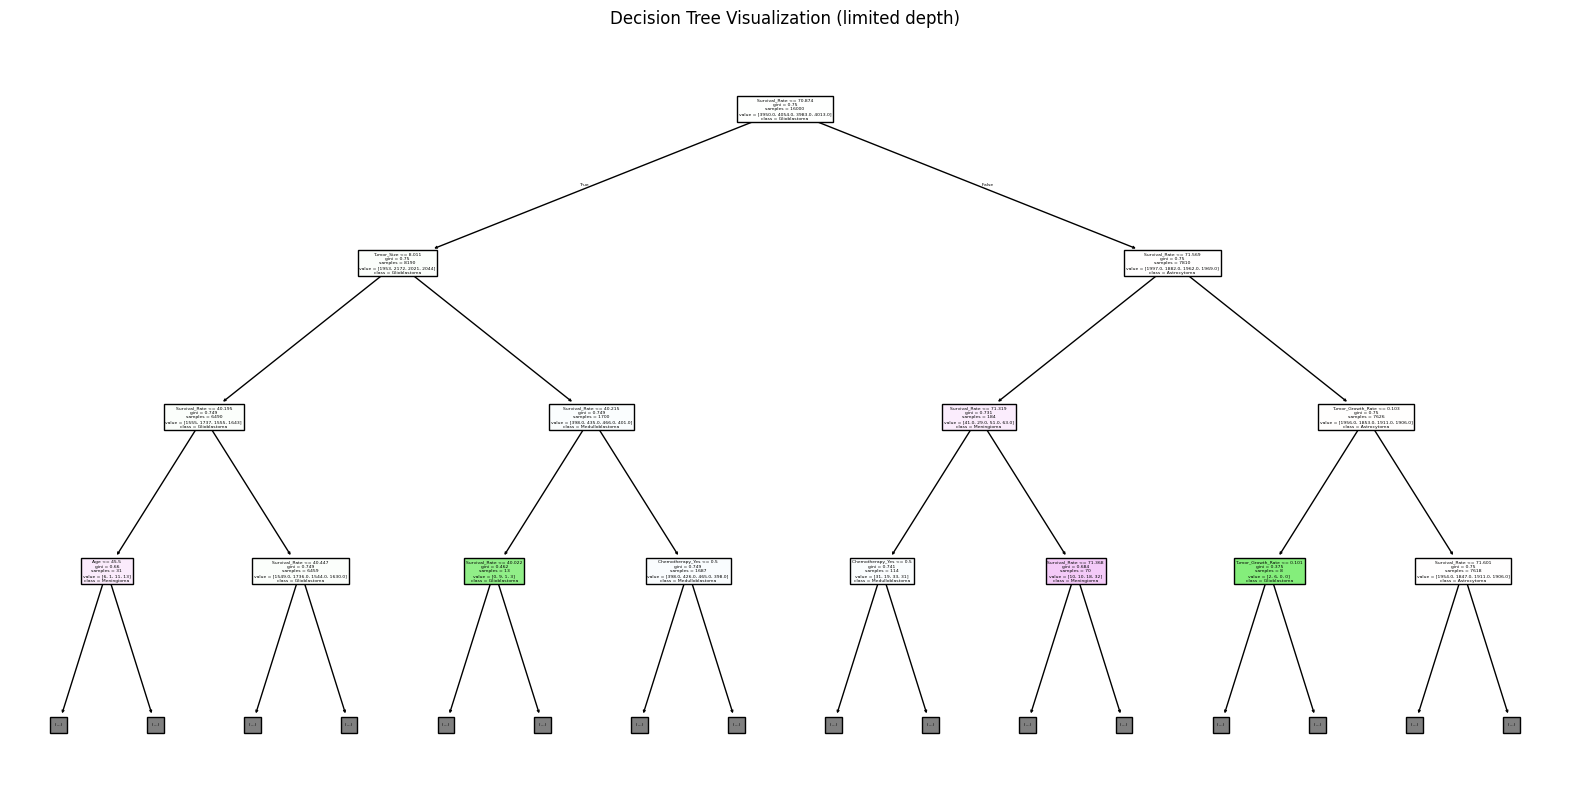

In [60]:
# Predictions on training set
y_train_pred = dt_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predictions on test set
y_test_pred = dt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualize the decision tree (limited depth for clarity)
plt.figure(figsize=(20,10))
tree.plot_tree(dt_model, filled=True, feature_names=new_cols, class_names=le.classes_, max_depth=3)
plt.title("Decision Tree Visualization (limited depth)")
plt.show()

This model performs really poorly

This is because Decision Tree Classifiers works well with data with >= 500 features.